# Module 7 Lab

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize ,
poly ,
ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [2]:
from pygam import (s as s_gam ,
l as l_gam,
f as f_gam,
LinearGAM ,
LogisticGAM)
from ISLP.transforms import (BSpline ,
NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam ,
degrees_of_freedom ,
plot as plot_gam ,
anova as anova_gam)

## Polynomial Regression and Step Functions

In [3]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [4]:
poly_age = MS([poly('age', degree = 4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


Fitting without transforming stores the recomputes the attributes

In [5]:
# create a grid for predictions
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age':age_grid})

In [6]:
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha = 0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age, y, facecolor = 'gray', alpha = 0.5)
    for val, ls in zip([preds.predicted_mean, bands[:, 0], bands[:,1]],
                       ['b', 'r--', 'r--']):
        ax.plot(age_df.values, val, ls, linewidth = 3)
        ax.set_title(title, fontsize = 20)
        ax.set_xlabel('Age', fontsize = 20)
        ax.set_ylabel('Wage', fontsize = 20)
        return ax
    

<Axes: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

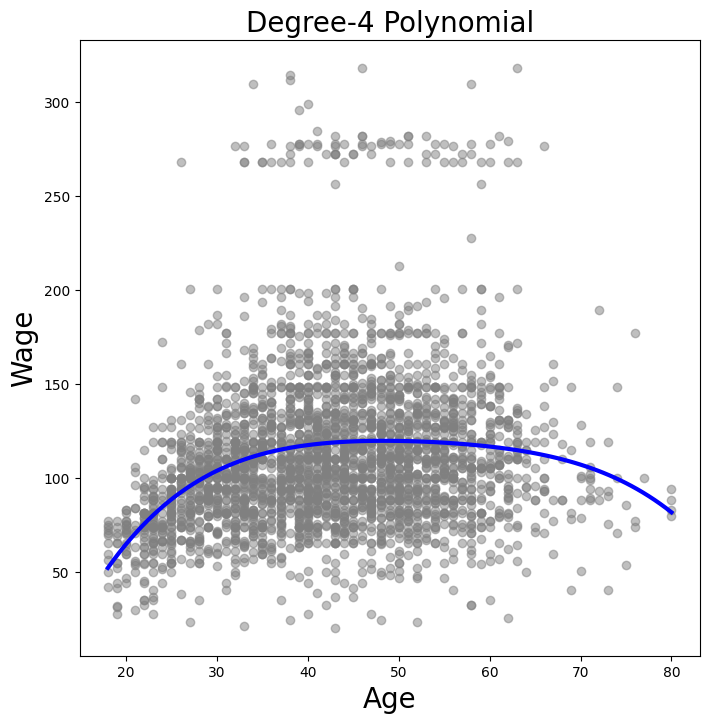

In [7]:
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial')

In [8]:
# we can use anova to find the simplest model (lowest degree) that explains the relationship based on an F-test
# comparing one simpler model to one more complex model
models = [MS([poly('age', degree = d)]) for d in range(1,6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


Linear and quadratic are insufficient, cubic or quartic seem like best fit while degree-five polynomial is too much.

ANOVA works whether or not the polynomials are orthogonal. 

In [9]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


## Splines

In [10]:
bs_ = BSpline(internal_knots=[25, 40, 60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape
# basis functions for splines with specified set of knots
# default is cubic for continuous splines

(3000, 7)

In [11]:
# number of degrees of freedom is 4+K where K is the number of knots, for cubic splines
bs_age = MS([bs('age', internal_knots = [25, 40, 60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In [12]:
# discards a basis function to account for intercept.
# if you specify df instead of knots, it will generate uniform knots
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


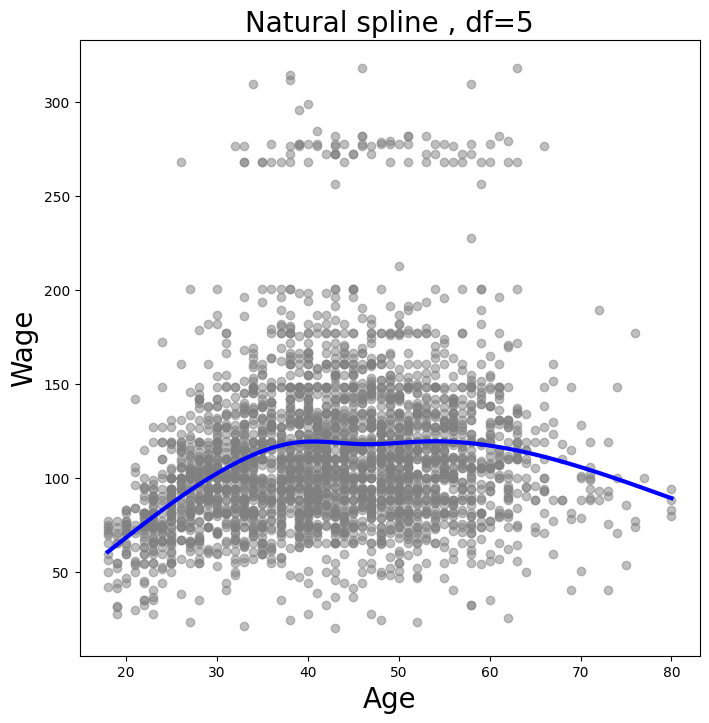

In [13]:
plot_wage_fit(age_df ,
ns_age ,
'Natural spline , df=5');

## Smoothing Splines and GAMs

In [14]:
# smoothing spline is GAM with one feature and squared-error loss
X_age = np.asarray(age).reshape((-1, 1))
gam = LinearGAM(s_gam(0, lam = 0.6))
gam.fit(X_age, y)


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

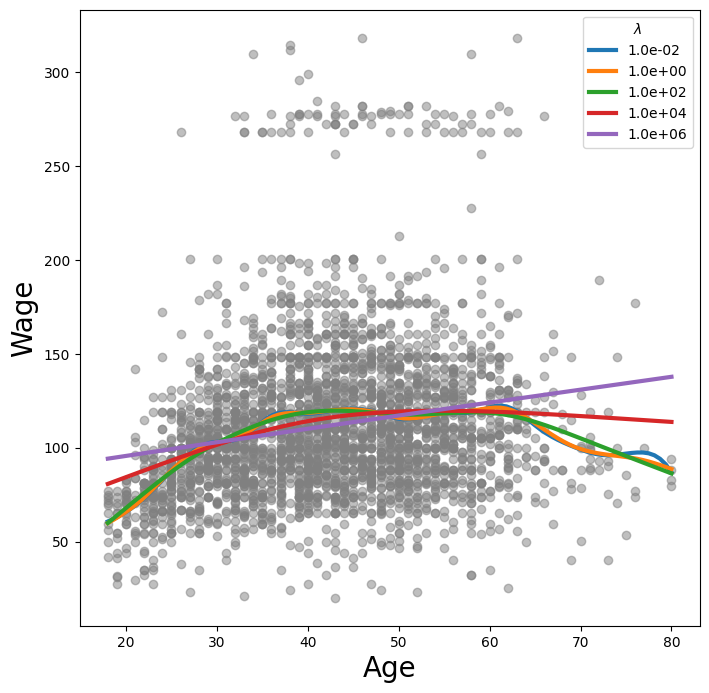

In [16]:
fig , ax = subplots(figsize=(8,8))
ax.scatter(age , y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age , y)
    ax.plot(age_grid ,
gam.predict(age_grid),
label='{:.1e}'.format(lam),
linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


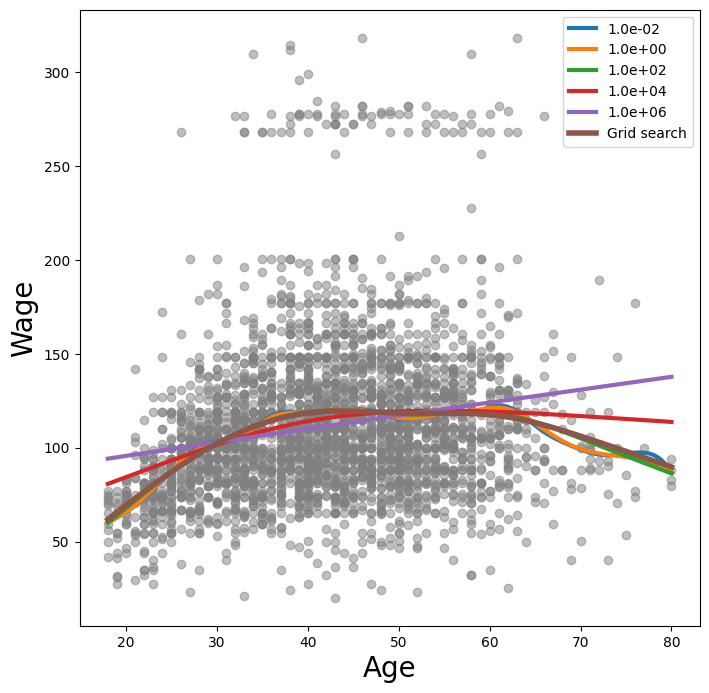

In [17]:
# because there is an unpenalized intercept and linear term, there are at least two degrees of freedom
gam_opt = gam.gridsearch(X_age , y)
ax.plot(age_grid ,
gam_opt.predict(age_grid),
label='Grid search',
linewidth=4)
ax.legend()
fig

In [18]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age , age_term , 4)
age_term.lam = lam_4
degrees_of_freedom(X_age , age_term)

4.000000100001664

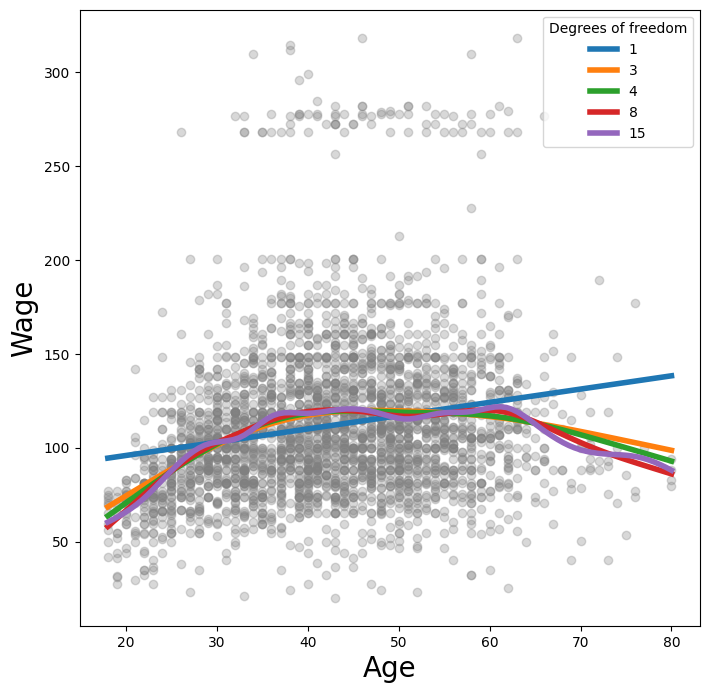

In [19]:
fig, ax = subplots(figsize = (8,8))
ax.scatter(X_age, y, facecolor = 'gray', alpha = 0.3)
for df in [1, 3, 4, 8, 15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid, gam.predict(age_grid),
            label = '{:d}'.format(df), linewidth = 4)
ax.set_xlabel('Age', fontsize = 20)
ax.set_ylabel('Wage', fontsize = 20)
ax.legend(title = 'Degrees of freedom')

In [20]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

Text(0.5, 1.0, 'Partial dependence of age on wage')

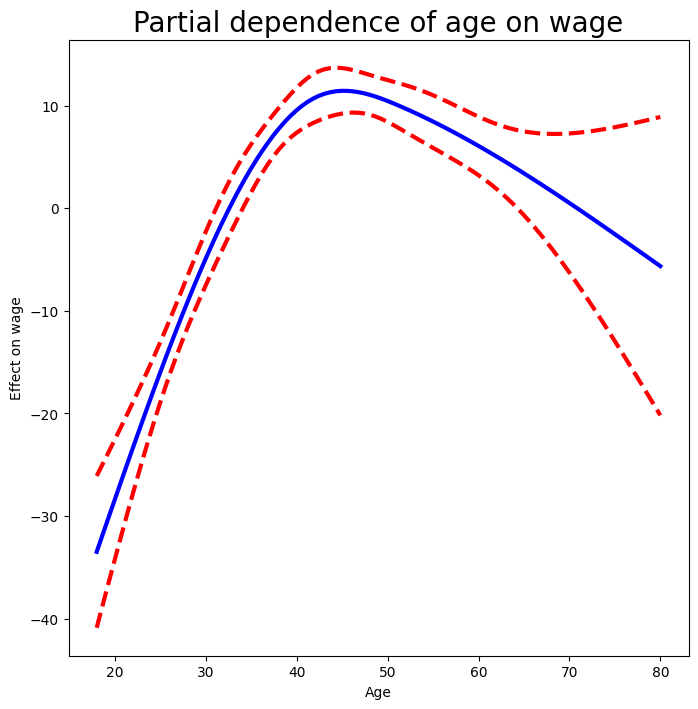

In [21]:
age_grid = np.linspace(age.min(), age.max(), 100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None, :]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha = 0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize = (8,8))
ax.plot(age_grid, partial_age, 'b', linewidth = 3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth = 3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth = 3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize = 20)

In [ ]:
# create matrix of age, where the four columns for age are fitted values from the natuarl spline basis evaluted at 100 values in tthe grid
# all other variables are held at their mean


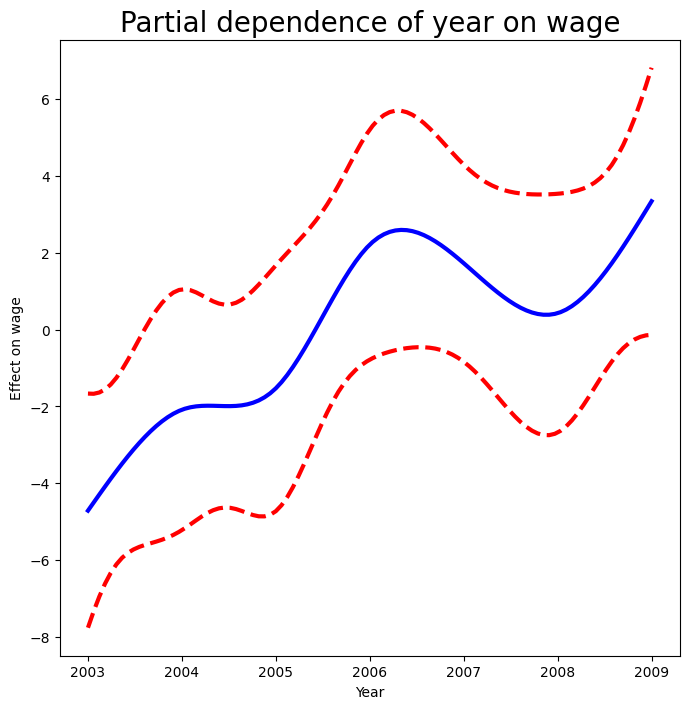

In [22]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
Wage['year'].max(),
100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None ,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha =0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig , ax = subplots(figsize=(8,8))
ax.plot(year_grid , partial_year , 'b', linewidth=3)
ax.plot(year_grid , bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid , bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

In [23]:
gam_full = LinearGAM(s_gam(0) +
s_gam(1, n_splines=7) +
f_gam(2, lam=0))
Xgam = np.column_stack([age ,
Wage['year'],
Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam , y)

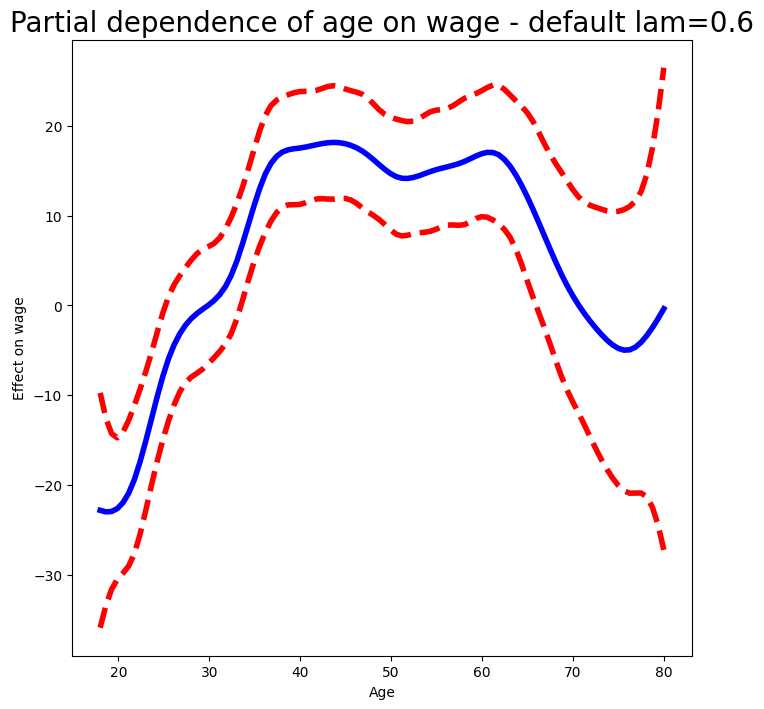

In [24]:
fig , ax = subplots(figsize=(8,8))
plot_gam(gam_full , 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6',
fontsize=20);

In [25]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam , age_term , df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam , year_term , df=4+1)
gam_full = gam_full.fit(Xgam , y)

Text(0.5, 1.0, 'Partial dependence of year on wage')

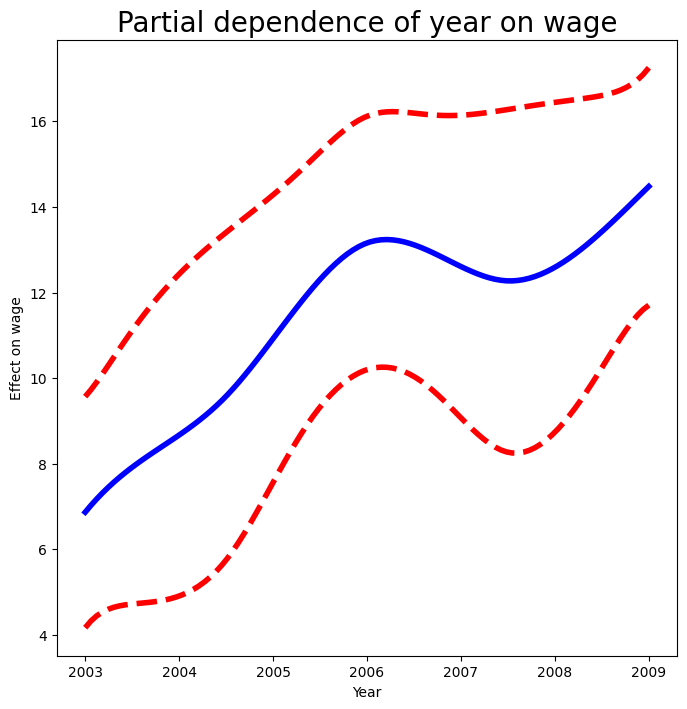

In [26]:
fig , ax = subplots(figsize=(8,8))
plot_gam(gam_full ,
1,
ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

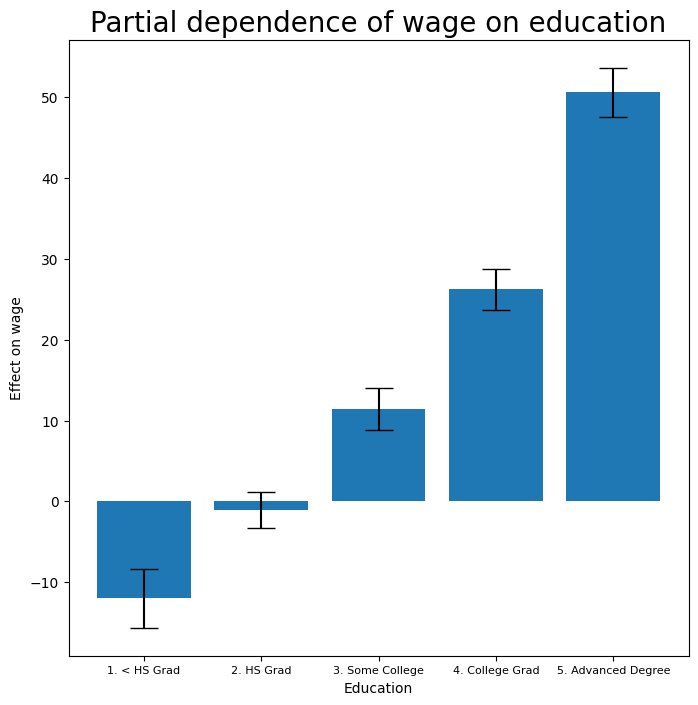

In [27]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full , 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize =20);
ax.set_xticklabels(Wage['education'].cat.categories , fontsize =8);